In [1]:
%pylab inline
from ipywidgets import interact
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


# Piecewise Linear Interpolation

References: https://cds.cern.ch/record/1456844/files/CERN-OPEN-2012-016.pdf

We wish to understand interpolation using the piecewise linear function. This is `interpcode=0` in the above reference. This function is defined as (nb: vector denotes bold)

$$
\eta_s (\vec{\alpha}) = \sigma_{sb}^0(\vec{\alpha}) + \underbrace{\sum_{p \in \text{Syst}} I_\text{lin.} (\alpha_p; \sigma_{sb}^0, \sigma_{psb}^+, \sigma_{psb}^-)}_\text{deltas to calculate}
$$

with

$$
I_\text{lin.}(\alpha; I^0, I^+, I^-) = \begin{cases} \alpha(I^+ - I^0) \qquad \alpha \geq 0\\ \alpha(I^0 - I^-) \qquad \alpha < 0 \end{cases}
$$

In this notebook, we'll demonstrate the technical implementation of these interplations starting from simple dimensionality and increasing the dimensions as we go along. In all situations, we'll consider a single systematic that we wish to interpolate, such as Jet Energy Scale (JES).

Let's define the interpolate function. This function will produce the deltas we would like to calculate and sum with the nominal measurement to determine the interpolated measurements value.

In [2]:
def interpolate_deltas(down,nom,up,alpha):
    delta_up = up - nom
    delta_down = nom - down
    if alpha > 0:
        return delta_up*alpha
    else:
        return delta_down*alpha

Why are we calculating deltas? This is some additional foresight that you, the reader, may not have yet. Multiple interpolation schemes exist but they all rely on calculating the change with respect to the nominal measurement (the delta).

## Case 1: The Single-binned Histogram

Let's first start with considering evaluating the total number of events after applying JES corrections. This is the single-bin case. Code that runs through event selection will vary the JES parameter and provide three histograms, each with a single bin. These three histograms represent the nominal-, up-, and down- variations of the JES nuisance parameter.

When processing, we find that there are 10 events nominally, and when we vary the JES parameter downwards, we only measure 8 events. When varying upwards, we measure 15 events.

In [3]:
down_1 = np.array([8])
nom_1  = np.array([10])
up_1   = np.array([15])

We would like to generate a function $f(\alpha_\text{JES})$ that linearly interpolates the number of events for us so we can scan the phase-space for calculating PDFs. The `interpolate_deltas()` function defined above does this for us.

In [4]:
alphas = np.linspace(-1.,1.)
deltas = [interpolate_deltas(down_1, nom_1, up_1, alpha) for alpha in alphas]
deltas[:5]

[array([-2.]),
 array([-1.91836735]),
 array([-1.83673469]),
 array([-1.75510204]),
 array([-1.67346939])]

So now that we've generated the deltas from the nominal measurement, we can plot this to see how the linear interpolation works in the single-bin case, where we plot the measured values in black, and the interpolation in dashed, blue.

Text(0,0.5,'Events')

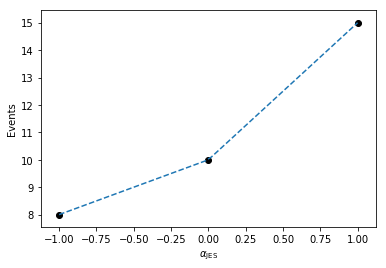

In [5]:
plt.plot(alphas,[nom_1+delta for delta in deltas], linestyle='--')
plt.scatter((-1,0,1),(down_1,nom_1,up_1), color='k')
plt.xlabel(r'$\alpha_\mathrm{JES}$')
plt.ylabel(r'Events')

Here, we can imagine building a 1-dimensional tensor (column-vector) of measurements as a function of $\alpha_\text{JES}$ with each row in the column vector corresponding to a given $\alpha_\text{JES}$ value.

## Case 2: The Multi-binned Histogram

Now, let's increase the computational difficulty a little by increasing the dimensionality. Assume instead of a single-bin measurement, we have more measurements! We are good physicists after all. Imagine continuing on the previous example, where we add more bins, perhaps because we got more data. Imagine that this was binned by collection year, where we observed 10 events in the first year, 10.5 the next year, and so on...

In [6]:
down_hist = np.linspace(8,10,11)
nom_hist = np.linspace(10,13,11)
up_hist = np.linspace(15,20,11)

Now, we still need to interpolate. Just like before, we have varied JES upwards and downwards to determine the corresponding histograms of variations. In order to interpolate, we need to interpolate by bin for each bin in the three histograms we have here (or three measurements if you prefer).

Let's go ahead and plot these histograms as a function of the bin index with black as the nominal measurements, red and blue as the down and up variations respectively. The black points are the measurements we have, and for each bin, we would like to interpolate to get an interpolated histogram that represents the measurement as a function of $\alpha_\text{JES}$.

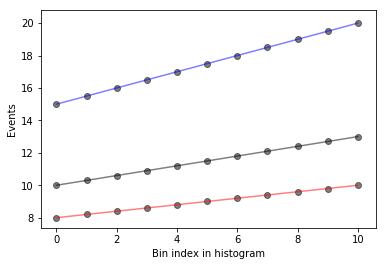

In [7]:
def plot_measurements(down_hist, nom_hist, up_hist):
    bincenters = np.arange(len(nom_hist))
    for i, h in enumerate(zip(up_hist, nom_hist, down_hist)):
        plt.scatter([i]*len(h), h, color='k', alpha=0.5)

    for c,h in zip(['r','k','b'],[down_hist, nom_hist, up_hist]):
        plt.plot(bincenters, h, color=c, linestyle='-', alpha=0.5)

    plt.xlabel('Bin index in histogram')
    plt.ylabel('Events')
    
plot_measurements(down_hist, nom_hist, up_hist)

What does this look like if we evaluate at a single $\alpha_\text{JES} = 0.5$? We'll write a function that interpolates and then plots the interpolated values as a function of bin index, in green, dashed.

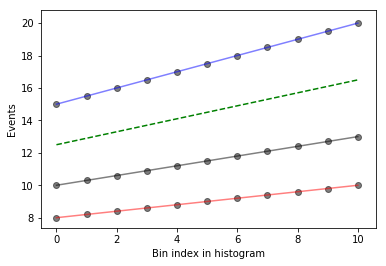

In [8]:
def plot_interpolated_histogram(alpha, down_hist, nom_hist, up_hist):
    bincenters = np.arange(len(nom_hist))
    interpolated_vals = [nominal + interpolate_deltas(down, nominal, up, alpha) for down, nominal, up in zip(down_hist,nom_hist,up_hist)]

    plot_measurements(down_hist, nom_hist, up_hist)
    plt.plot(bincenters,interpolated_vals, color = 'g', linestyle='--')
    
plot_interpolated_histogram(0.5, down_hist, nom_hist, up_hist)

We can go one step further in visualization and see what it looks like for different $\alpha_\text{JES}$ using iPyWidget's interactivity. Change the slider to get an idea of how the interpolation works.

In [9]:
x = interact(lambda alpha: plot_interpolated_histogram(alpha, down_hist, nom_hist, up_hist), alpha = (-1,1,0.1))

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdhbHBoYScsIG1heD0xLjAsIG1pbj0tMS4wKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXPigKY=


The magic in `plot_interpolated_histogram()` happens to be that for a given $\alpha_\text{JES}$, we iterate over all measurements bin-by-bin to calculate the interpolated value

```python
    [nominal + interpolate_deltas(down, nominal, up, alpha) for down, nominal, up in zip(...hists...)]
```

So you can imagine that we're building up a 2-dimensional tensor with each row corresponding to a different $\alpha_\text{JES}$ and each column corresponding to the bin index of the histograms (or measurements). Let's go ahead and build a 3-dimensional representation of our understanding so far!

In [10]:
def interpolate_alpha_range(alphas, down_hist, nom_hist, up_hist):
    at_alphas = []
    for alpha in alphas:
        interpolated_hist_at_alpha = [nominal + interpolate_deltas(down, nominal, up, alpha) for down, nominal, up in zip(down_hist, nom_hist, up_hist)]
        at_alphas.append(interpolated_hist_at_alpha)
    return np.array(at_alphas)

And then with this, we are interpolating over all histograms bin-by-bin and producing a 2-dimensional tensor with each row corresponding to a specific value of $\alpha_\text{JES}$.

In [11]:
alphas = np.linspace(-1,1,11)

interpolated_vals_at_alphas = interpolate_alpha_range(alphas, down_hist, nom_hist, up_hist)

print(interpolated_vals_at_alphas[alphas==-1])
print(interpolated_vals_at_alphas[alphas==0])
print(interpolated_vals_at_alphas[alphas==1])

[[ 8.   8.2  8.4  8.6  8.8  9.   9.2  9.4  9.6  9.8 10. ]]
[[10.  10.3 10.6 10.9 11.2 11.5 11.8 12.1 12.4 12.7 13. ]]
[[15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20. ]]


We have a way to generate the 2-dimensional tensor. Let's go ahead and add in all dimensions. Additionally, we'll add in some extra code to show the projection of the 2-d plots that we made earlier to help understand the 3-d plot a bit better. Like before, let's plot specifically colored lines for $\alpha_\text{JES}=0.5$ as well as provide an interactive session.

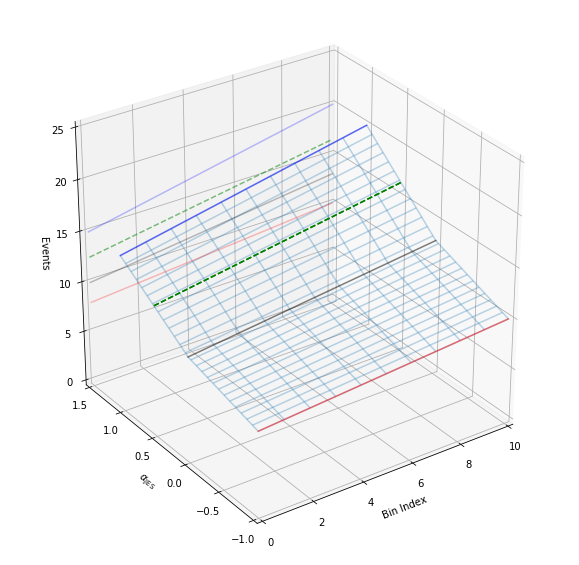

aW50ZXJhY3RpdmUoY2hpbGRyZW49KEZsb2F0U2xpZGVyKHZhbHVlPTAuMCwgZGVzY3JpcHRpb249dSdhbHBoYScsIG1heD0xLjAsIG1pbj0tMS4wKSwgT3V0cHV0KCkpLCBfZG9tX2NsYXNzZXPigKY=


<function __main__.plot_wire>

In [13]:
def plot_wire(alpha):
    alphas = np.linspace(-1,1,51)
    at_alphas = interpolate_alpha_range(alphas, down_hist, nom_hist, up_hist)
    bincenters = np.arange(len(nom_hist))
    x,y = np.meshgrid(bincenters,alphas)
    z = np.asarray(at_alphas)
    bottom = np.zeros_like(x)
    fig = plt.figure(figsize=(10, 10))
    ax1 = fig.add_subplot(111, projection='3d')
    ax1.plot_wireframe(x, y, z, alpha = 0.3)

    
    x,y = np.meshgrid(bincenters,[alpha])
    z = interpolate_alpha_range([alpha], down_hist, nom_hist, up_hist)

    ax1.plot_wireframe(x, y, z, edgecolor = 'g', linestyle='--')
    ax1.set_xlim(0,10)
    ax1.set_ylim(-1.0,1.5)
    ax1.set_zlim(0,25)
    ax1.view_init(azim=-125)
    ax1.set_xlabel('Bin Index')
    ax1.set_ylabel(r'$\alpha_\mathrm{JES}$')
    ax1.set_zlabel('Events')
    
    # add in 2D plot goodness

    for c,h,zs in zip(['r','k','b'],[down_hist, nom_hist, up_hist],[-1.0,0.0,1.0]):
        ax1.plot(bincenters, h, color=c, linestyle='-', alpha=0.5, zdir='y', zs=zs)
        ax1.plot(bincenters, h, color=c, linestyle='-', alpha=0.25, zdir='y', zs=1.5)
    
    ax1.plot(bincenters, z.T, color = 'g', linestyle='--', zdir='y', zs=alpha)
    ax1.plot(bincenters, z.T, color = 'g', linestyle='--', alpha=0.5, zdir='y', zs=1.5)

    
    plt.show()
    
plot_wire(0.5)

interact(plot_wire,alpha = (-1,1,0.1))